## Detecting Hate & Offensive Speech

Dataset Source: https://www.kaggle.com/datasets/subhajournal/normal-hate-and-offensive-speeches

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed, DataCollatorWithPadding

import evaluate

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.7 
         NumPy: 1.23.3
        Pandas: 1.4.4
      Datasets: 2.8.0
  Transformers: 4.26.0
         Torch: 1.12.1
      Evaluate: 0.2.2


#### Load & Start Preprocessing Dataset

In [3]:
parent_dir = "data"

unique_classes = ["Normal", "Hate", "Offensive"]

data = pd.DataFrame()

### loop through all three classes ('Normal', 'Hate', 'Offensive')
for class_name in unique_classes:
    for x in range(4):
        temp_df = pd.DataFrame()
        file_name = class_name + "_Speeches_" + str(x + 1) + ".csv"
        data_file_name = os.path.join(parent_dir, file_name)
        temp_df = pd.read_csv(data_file_name, usecols=[3])
        temp_df['label'] = class_name
        data = pd.concat([temp_df, data]) 

data.rename(columns={"full_text": "text"}, inplace=True)

data

,text,label
0,Republicans need to go on the offensive! They ...,Offensive
1,&gt; Make fun of people who lost their familie...,Offensive
2,You're missing my point entirely. I don't give...,Offensive
3,Wet leg quoting Alex turner’s Brit acceptance ...,Offensive
4,"@SammiePressdee Sir Stephen Sedley said: ""Free...",Offensive
...,...,...
218,@KumudShankar @nandtara @MoatasimSolkar @Gauta...,Normal
219,There’s no point dropping speech when he is no...,Normal
220,harry is one of the most humble musicians i kn...,Normal
221,Bro want the biggest most political arc in rec...,Normal


#### Define Dictionaries to Convert Between String & Integer Class Values

In [4]:
id2label = {idx:label for idx, label in enumerate(unique_classes)}
label2id = {label:idx for idx, label in enumerate(unique_classes)}
NUM_OF_LABELS = len(unique_classes)

#### Visual: Histogram of Text Lengths

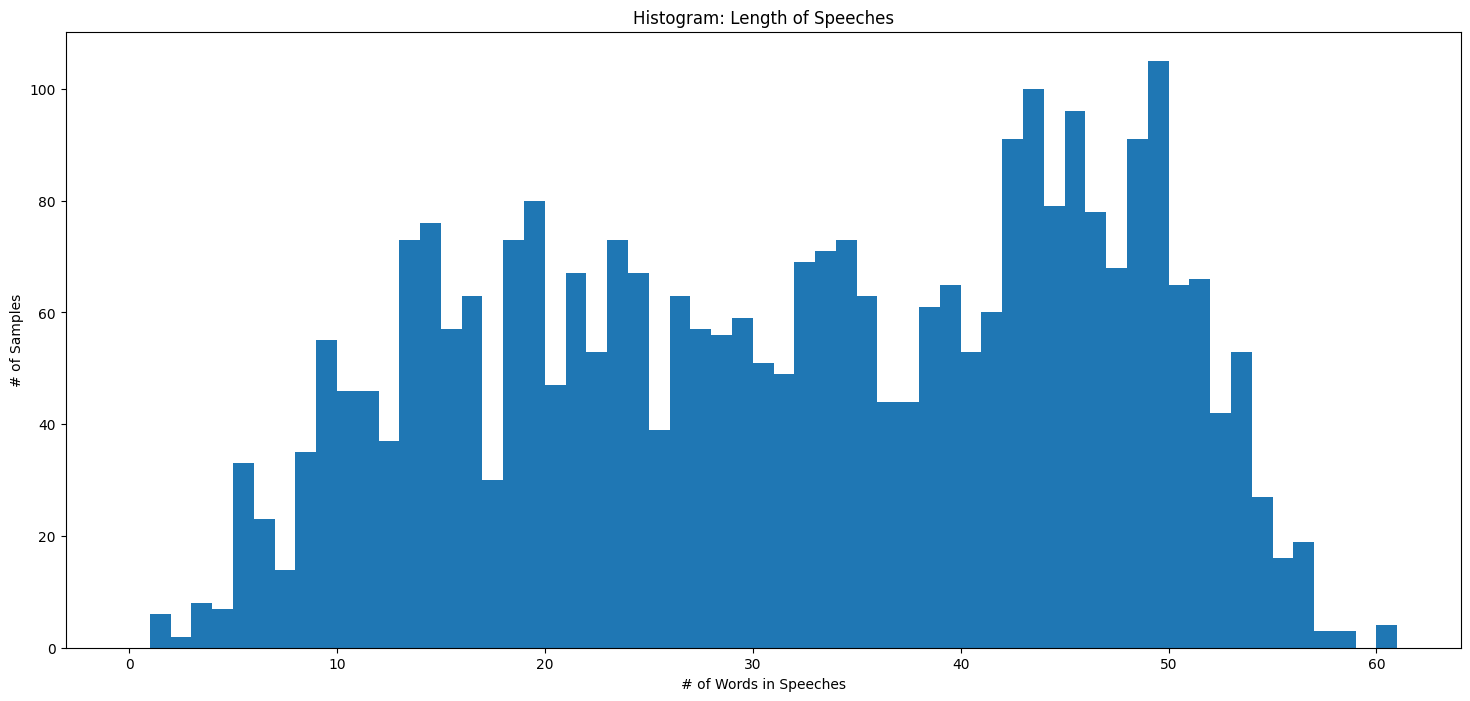

The maximum length of Speeches is 88 words.


In [5]:
data['text_length'] = data['text'].str.split().str.len()

n_bin=61
data.hist('text_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Speeches')
plt.xlabel('# of Words in Speeches')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of Speeches is {max(data['text_length'])} words.")

#### Visual: Tweet Length by Class

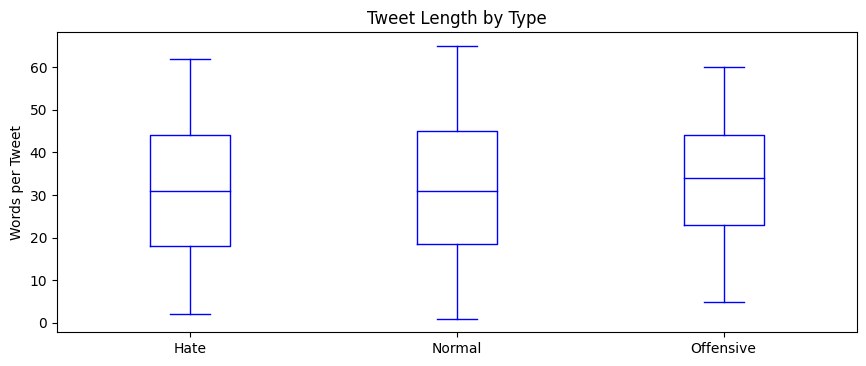

In [6]:
data.boxplot("text_length", by="label", grid=False, showfliers=False, color="Blue", figsize=(10,4))

plt.suptitle('')
plt.title('Tweet Length by Type')
plt.xlabel('')
plt.ylabel('Words per Tweet')
plt.show()

#### Final Data Preprocessing

In [7]:
data = data[data["text_length"] < 61]

data = data.drop(columns=["text_length"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3054 entries, 0 to 222
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3054 non-null   object
 1   label   3054 non-null   object
dtypes: object(2)
memory usage: 71.6+ KB


#### Number of Samples in Each Class

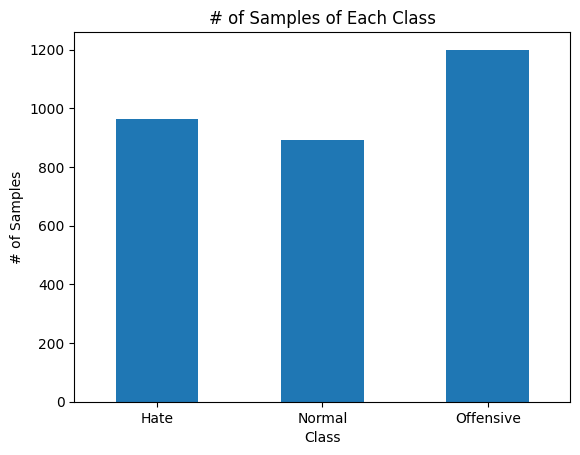

In [8]:
class_counts = data.groupby("label").count()

class_counts.plot.bar()
plt.suptitle('')
plt.title('# of Samples of Each Class')
plt.xlabel('Class')
plt.ylabel('# of Samples')
plt.xticks(rotation = 0)
plt.legend('', frameon=False)
plt.show()

#### Convert Class Values From String to Integer & Convert DataFrame to Dataset

In [9]:
data = data.replace(label2id)

dataset = Dataset.from_pandas(data)

#### Split Dataset into Training, Testing & Evaluation Datasets

In [10]:
train_eval = dataset.train_test_split(train_size=0.80)

ds = DatasetDict({
    'train' : train_eval['train'],
    'eval' : train_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

Training Dataset Shape: (2443, 3)
Evaluation Dataset Shape: (611, 3)


#### Basic Values/Constants

In [11]:
set_seed = 42
NUM_OF_EPOCHS = 5

BATCH_SIZE = 64
LEARNING_RATE = 2e-5

MAX_LENGTH = int(60 * 1.3)
MODEL_CKPT = "bert-large-uncased"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Hate_Offensive_or_Normal_Speech"

METRIC_NAME = "f1"
DEVICE = torch.device("cpu")

print(f"This project will utilize the {str(DEVICE).upper()} to train and evaluate.")
print(f"This project will have a maximum length for the input text of {MAX_LENGTH} tokens.")
print(f"The model checkpoint used for this project is: {MODEL_CKPT}")

This project will utilize the CPU to train and evaluate.
This project will have a maximum length for the input text of 78 tokens.
The model checkpoint used for this project is: bert-large-uncased


#### Tokenize Entire Dataset

In [12]:
# Define Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Tokenize Method
def tokenize(batch):
    return tokenizer(batch['text'], 
                     padding=True, 
                     truncation=True, 
                     max_length=MAX_LENGTH, 
                     return_tensors="pt")

# Map tokenizer method to entire dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)

print('Training data shape:', encoded_data['train'].shape)
print('Validation data shape:', encoded_data['eval'].shape)

print(encoded_data['train'].features)
print(encoded_data['train'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Training data shape: (2443, 6)
Validation data shape: (611, 6)
{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2443
})


#### Instantiate Model

In [13]:
model = (
    AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=NUM_OF_LABELS
    ).to(DEVICE))

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

#### Define Function to Compute Metrics

In [14]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define TrainingArguments

In [15]:
training_args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE, 
    per_device_eval_batch_size=BATCH_SIZE, 
    weight_decay=0.01,
    log_level="error",
    logging_strategy='epoch', 
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_first_step=True,
    load_best_model_at_end=True,
    disable_tqdm=False,
    hub_private_repo=True,
    push_to_hub=True
)

#### Define Data Collator

In [16]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

#### Subclass Trainer to Handle Class Imbalance

In [17]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [18]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['eval'], 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/bert-large-uncased-Hate_Offensive_or_Normal_Speech into local empty directory.


#### Train Model

In [19]:
train_results = trainer.train()

/Users/leedunn/Documents/nlpnn/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/195 [00:00<?, ?it/s]

{'loss': 1.6668, 'learning_rate': 1.98974358974359e-05, 'epoch': 0.03}
{'loss': 0.7991, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.42353054881095886, 'eval_accuracy': 0.7430441898527005, 'eval_Weighted F1': 0.7100455875952821, 'eval_Micro F1': 0.7430441898527005, 'eval_Macro F1': 0.6901882122826978, 'eval_Weighted Recall': 0.7430441898527005, 'eval_Micro Recall': 0.7430441898527005, 'eval_Macro Recall': 0.7049309175146852, 'eval_Weighted Precision': 0.7781623048510729, 'eval_Micro Precision': 0.7430441898527005, 'eval_Macro Precision': 0.7886298016225889, 'eval_runtime': 442.521, 'eval_samples_per_second': 1.381, 'eval_steps_per_second': 0.023, 'epoch': 1.0}
{'loss': 0.2156, 'learning_rate': 1.2e-05, 'epoch': 2.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.10715224593877792, 'eval_accuracy': 0.9607201309328969, 'eval_Weighted F1': 0.960521262215524, 'eval_Micro F1': 0.9607201309328969, 'eval_Macro F1': 0.958477332112127, 'eval_Weighted Recall': 0.9607201309328969, 'eval_Micro Recall': 0.9607201309328969, 'eval_Macro Recall': 0.9568917018284107, 'eval_Weighted Precision': 0.960742914068959, 'eval_Micro Precision': 0.9607201309328969, 'eval_Macro Precision': 0.9605319776597775, 'eval_runtime': 510.6914, 'eval_samples_per_second': 1.196, 'eval_steps_per_second': 0.02, 'epoch': 2.0}
{'loss': 0.0518, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.051800940185785294, 'eval_accuracy': 0.9869067103109657, 'eval_Weighted F1': 0.9868802978484879, 'eval_Micro F1': 0.9869067103109657, 'eval_Macro F1': 0.9863153577654783, 'eval_Weighted Recall': 0.9869067103109657, 'eval_Micro Recall': 0.9869067103109657, 'eval_Macro Recall': 0.9857491519814677, 'eval_Weighted Precision': 0.9869162080391105, 'eval_Micro Precision': 0.9869067103109657, 'eval_Macro Precision': 0.9869519344276284, 'eval_runtime': 439.5395, 'eval_samples_per_second': 1.39, 'eval_steps_per_second': 0.023, 'epoch': 3.0}
{'loss': 0.0242, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.0500081405043602, 'eval_accuracy': 0.9852700490998363, 'eval_Weighted F1': 0.9852499296043848, 'eval_Micro F1': 0.9852700490998363, 'eval_Macro F1': 0.9845267020939886, 'eval_Weighted Recall': 0.9852700490998363, 'eval_Micro Recall': 0.9852700490998363, 'eval_Macro Recall': 0.9841151650533632, 'eval_Weighted Precision': 0.9852561782367332, 'eval_Micro Precision': 0.9852700490998363, 'eval_Macro Precision': 0.9849678895948624, 'eval_runtime': 441.5004, 'eval_samples_per_second': 1.384, 'eval_steps_per_second': 0.023, 'epoch': 4.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'loss': 0.0163, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.04433029890060425, 'eval_accuracy': 0.9869067103109657, 'eval_Weighted F1': 0.9868802978484879, 'eval_Micro F1': 0.9869067103109657, 'eval_Macro F1': 0.9863153577654783, 'eval_Weighted Recall': 0.9869067103109657, 'eval_Micro Recall': 0.9869067103109657, 'eval_Macro Recall': 0.9857491519814677, 'eval_Weighted Precision': 0.9869162080391105, 'eval_Micro Precision': 0.9869067103109657, 'eval_Macro Precision': 0.9869519344276284, 'eval_runtime': 434.1886, 'eval_samples_per_second': 1.407, 'eval_steps_per_second': 0.023, 'epoch': 5.0}
{'train_runtime': 50788.9347, 'train_samples_per_second': 0.241, 'train_steps_per_second': 0.004, 'train_loss': 0.2258462979243352, 'epoch': 5.0}


#### Save Model & Metrics on Training Dataset

In [20]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/1.25G [00:00<?, ?B/s]

Upload file runs/Apr16_00-08-29_Lees-Air/events.out.tfevents.1681621716.Lees-Air.1926.0:   0%|          | 1.00…

To https://huggingface.co/DunnBC22/bert-large-uncased-Hate_Offensive_or_Normal_Speech
   84d47da..affb66a  main -> main

To https://huggingface.co/DunnBC22/bert-large-uncased-Hate_Offensive_or_Normal_Speech
   affb66a..0b953fa  main -> main



***** train metrics *****
  epoch                    =         5.0
  train_loss               =      0.2258
  train_runtime            = 14:06:28.93
  train_samples_per_second =       0.241
  train_steps_per_second   =       0.004


#### Evaluate Model

In [21]:
metrics = trainer.evaluate(encoded_data['eval'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        5.0
  eval_Macro F1           =     0.9863
  eval_Macro Precision    =      0.987
  eval_Macro Recall       =     0.9857
  eval_Micro F1           =     0.9869
  eval_Micro Precision    =     0.9869
  eval_Micro Recall       =     0.9869
  eval_Weighted F1        =     0.9869
  eval_Weighted Precision =     0.9869
  eval_Weighted Recall    =     0.9869
  eval_accuracy           =     0.9869
  eval_loss               =     0.0443
  eval_runtime            = 0:07:34.94
  eval_samples_per_second =      1.343
  eval_steps_per_second   =      0.022


#### Push Model to HuggingFace Hub

In [23]:
trainer.push_to_hub(commit_message="All Dunn!!!")

### Notes & Other Takeaways From This Project
****
- This is a late addition to the comparison of models that predict if text/speech is hateful, offensive, or normal.
****

### Citations
- Model Checkpoint
    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}
